In [1]:
import pandas as pd
pd.options.display.max_colwidth = 5000
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [4]:
# character length of text snippet
train['text_length'] = train['text'].apply(len)

In [5]:
def split_text(x):
    return x.split()

In [6]:
# word count length of text snipped
train['word_count'] = train['text'].apply(split_text).apply(len)

In [7]:
train.describe()

,text_length,word_count
count,19579.000000,19579.000000
mean,149.057408,26.730477
std,106.800189,19.048353
min,21.000000,2.000000
25%,81.000000,15.000000
50%,128.000000,23.000000
75%,191.000000,34.000000
max,4663.000000,861.000000


## Training set

- MWS has unusually long text snippets compared to EAP and HPL

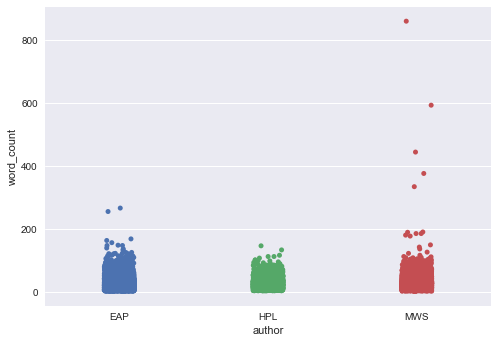

In [8]:
ax = sns.stripplot(x="author", y="word_count", data=train, jitter=True)

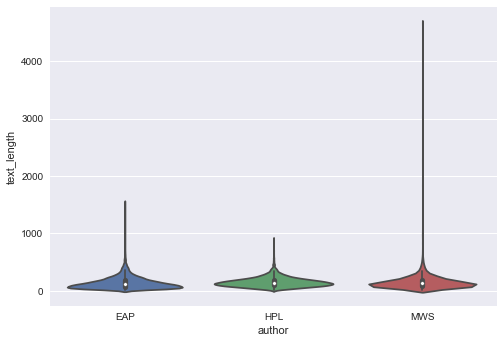

In [9]:
ax = sns.violinplot(x='author', y='text_length', data=train)

In [10]:
test['text_length'] = test['text'].apply(len)

## Test set

- We don't know the author
- There are not as many unusually long text snippets in the training set

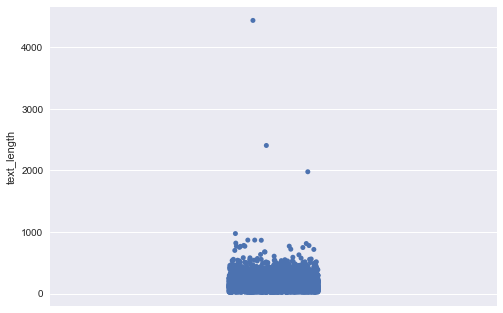

In [18]:
ax = sns.stripplot(y='text_length', data=test, jitter=True)